<h1 align='center'>Computing Wake Functions from FBPIC Simulations</h1>
<center>
Stephen D. Webb <br>
RadiaSoft, LLC <br>
swebb@radiasoft.net</center>

Developed for a project supported by the United States Department of Energy, Office of Science, Office of High Energy Physics under contract number DE-SC0018718.

In [1]:
## Imports

# standard python libraries
import numpy as np
from scipy import constants
from scipy.special import erfc, k0, k1, kn

import shutil, os

%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py as hdf5

# OpenPMD for looking at the file data
from opmd_viewer import OpenPMDTimeSeries

# set the colormap and centre the colorbar

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

## Reading in the Data

In [2]:
## Metadata
n_plasma = 4.e16        # cm^-3

# convert to per cubic meter
n_plasma *= 100**3

# derived plasma quantities
omega_p = np.sqrt(n_plasma*constants.elementary_charge**2/(constants.m_e*constants.epsilon_0))
k_p = omega_p/constants.c

drive_Q = 1.e10*(-1.*constants.elementary_charge)   # Coulombs

drive_sigma_z = 12.77e-6  # meters

dir_name = './blowout/diags/hdf5'
step_num = 3200

In [23]:
ts = OpenPMDTimeSeries(dir_name)
Ez_field, meta = ts.get_field(field='E', coord='z', iteration=step_num)
Er_field, meta = ts.get_field(field='E', coord='r', iteration=step_num)
Bt_field, meta = ts.get_field(field='B', coord='t', iteration=step_num)

zs, xs = ts.get_particle(var_list=['z', 'x'], species='electrons', iteration=step_num)

rgrid = meta.r
zgrid = meta.z

nr = meta.r.shape[0]
nz = meta.z.shape[0]

z0 = np.average(zs)*1.e-6

plt_extent=[(zgrid[0]-z0)*1.e6, (zgrid[-1]-z0)*1.e6, rgrid[0]*1.e6, rgrid[-1]*1.e6]
plt_extent_normed=[(k_p*(zgrid[0]-z0)),(k_p*(zgrid[-1]-z0)), rgrid[0]*1.e6, rgrid[-1]*1.e6]
aspect_ratio = np.abs(rgrid[0]/zgrid[0])/1.6

<IPython.core.display.Javascript object>


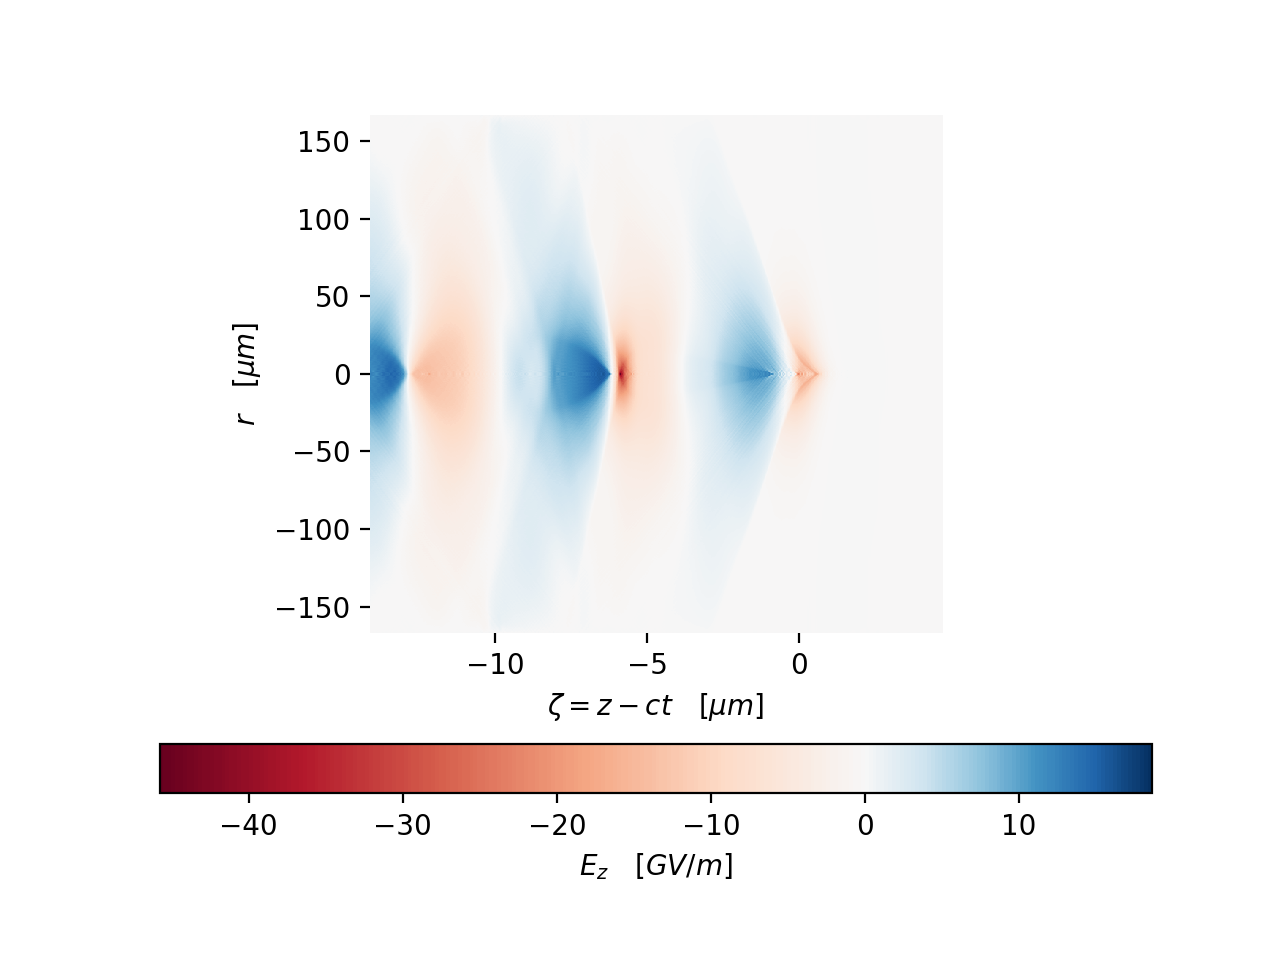

In [24]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

# Fix the midpoint to zero field

ezmax = np.amax(Ez_field*1.e-9)
ezmin = np.amin(Ez_field*1.e-9)
ezavg = 0.

plt.imshow(Ez_field*1.e-9, extent=plt_extent_normed,
           cmap='RdBu', origin='lower', aspect=aspect_ratio,
           norm=MidpointNormalize(midpoint=ezavg,vmin=ezmin, vmax=ezmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_z \quad [GV/m]$')

plt.savefig('Ez.png')

In [5]:
def compute_analytic_Ez(kp, sigma_z, Q, zeta):
        
    phase_arg = kp * zeta
    erfc_arg  = (zeta - 1.j*kp*sigma_z*sigma_z)/(np.sqrt(2)*sigma_z)
        
    Ez = np.exp(-1.j*phase_arg)*(erfc(erfc_arg))
    Ez = np.real(Ez)
    Ez *= Q * np.exp(- 0.5 * (kp * sigma_z)**2)/(2*np.pi*constants.epsilon_0)*k_p**2
    
    return Ez

<IPython.core.display.Javascript object>


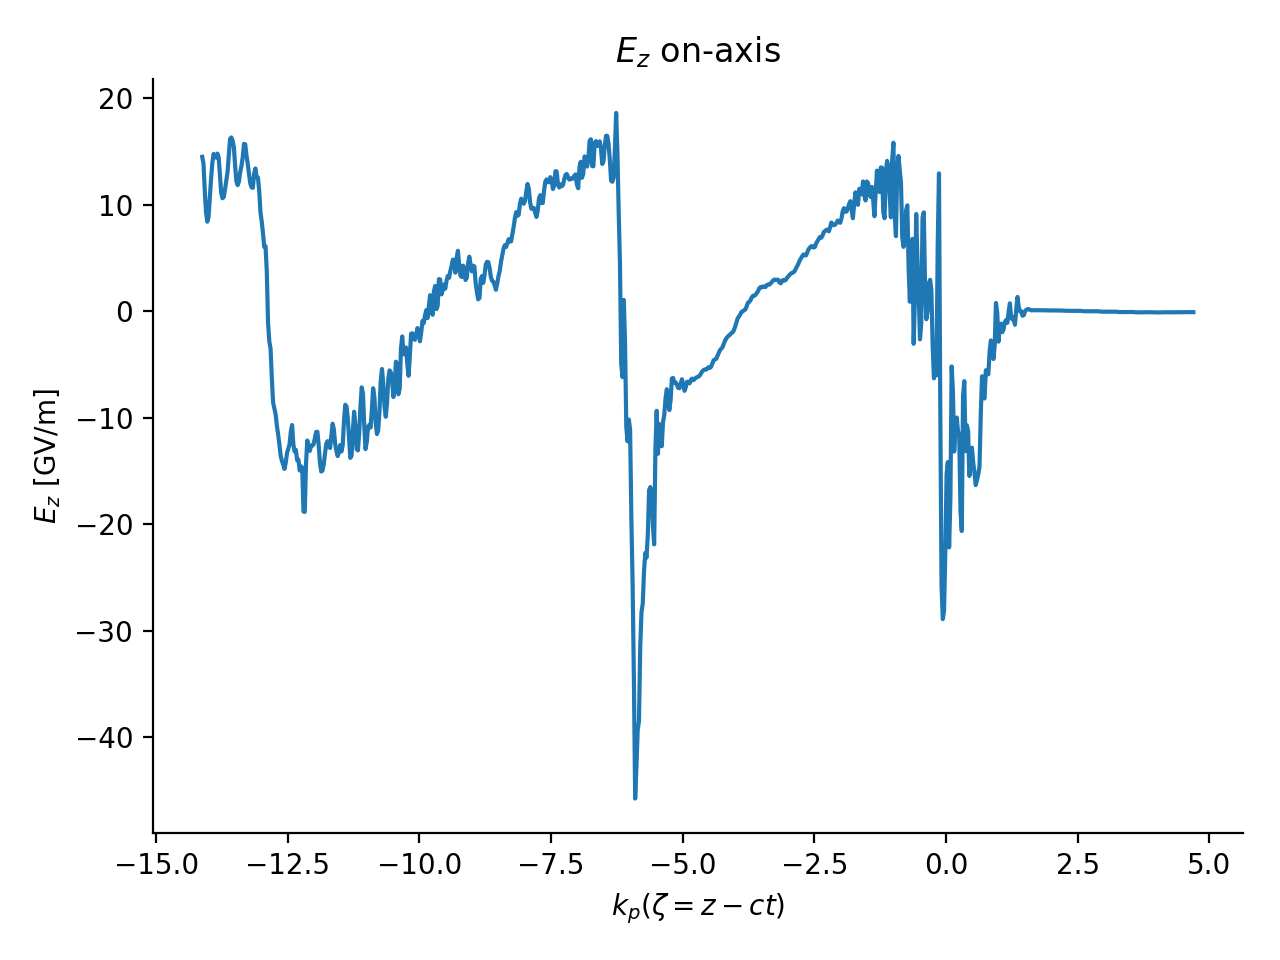

In [9]:
fig, ax = plt.subplots()

Ez = compute_analytic_Ez(k_p, drive_sigma_z, drive_Q, (zgrid-z0))

ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 

axis_idx = np.shape(Ez_field)[0]
plt.plot(k_p*(zgrid-z0),Ez_field[axis_idx/2,:]*1.e-9, label='sim.')
#plt.plot(k_p*(zgrid-z0),Ez*1.e-9, label='lin. theory')
plt.xlabel(r'$k_p (\zeta = z - ct)$')
plt.ylabel(r'$E_z$ [GV/m]')
#plt.legend()
plt.title('$E_z$ on-axis')
plt.tight_layout()

plt.savefig('Ez_on_axis.png')

<IPython.core.display.Javascript object>


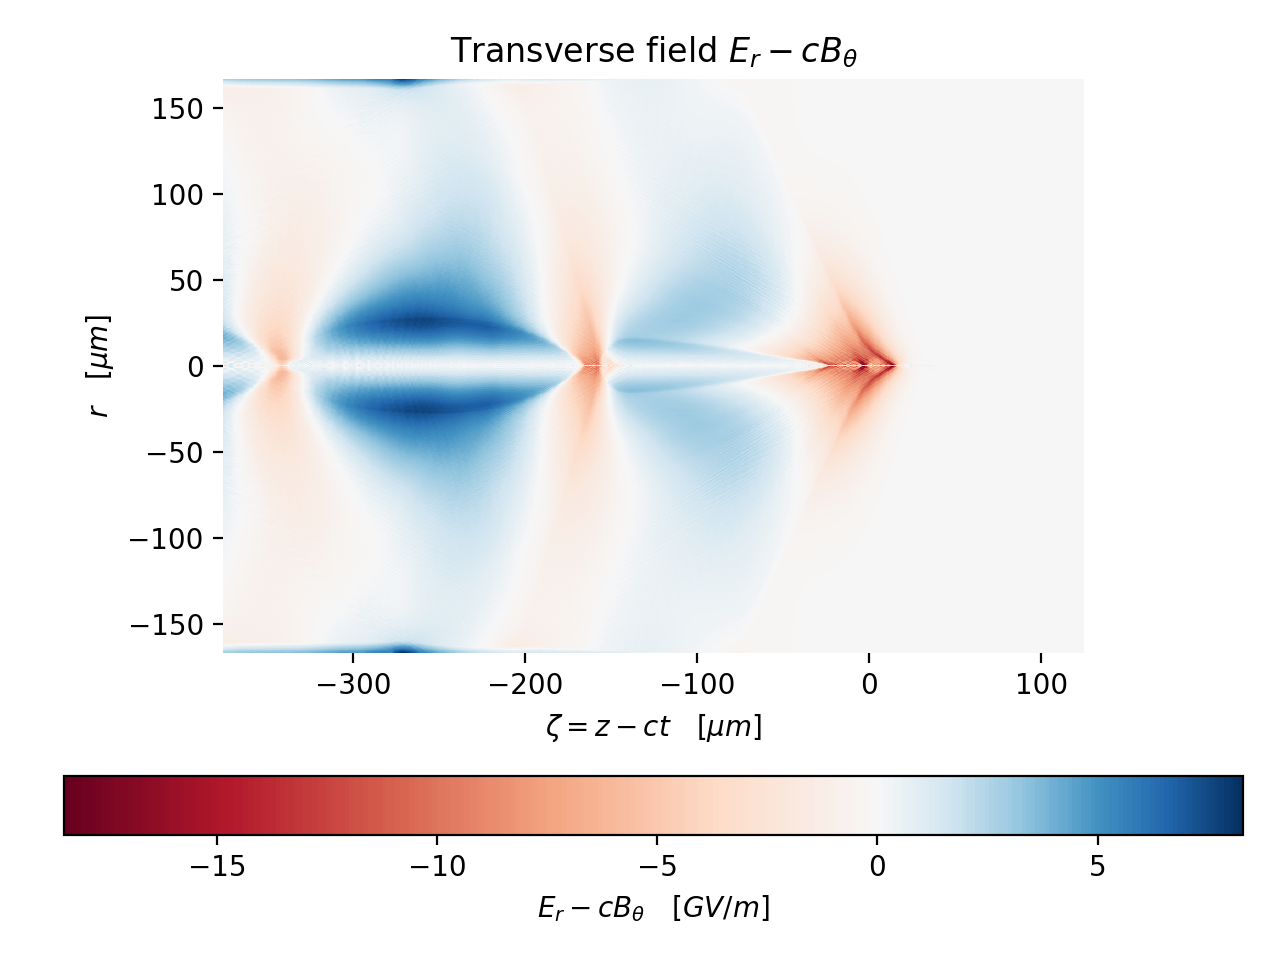

In [7]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
Fr = (Er_field - constants.speed_of_light*(Bt_field))*1.e-9

frmax = np.amax(Fr)
frmin = np.amin(Fr)
fravg = 0.

plt.imshow(Fr, extent=plt_extent,
           cmap='RdBu', origin='lower', 
           norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')
plt.title(r'Transverse field $E_r - c B_\theta$')
plt.tight_layout()

plt.savefig('transverse_field.png')